# Emotion Detection Dataset Analysis
## Exploratory Data Analysis for Music Recommendation System

This notebook performs comprehensive analysis of the FER2013 dataset to understand the data distribution, quality, and characteristics for building an emotion detection model for music recommendation.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter, defaultdict
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configuration
CONFIG = {
    'dataset_root': '../../data/raw/fer2013',
    'train_dir': '../../data/raw/fer2013/train',
    'test_dir': '../../data/raw/fer2013/test',
    'output_dir': '../../data/processed/FC211033_Sahan',
    'original_emotions': ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
    'music_relevant_emotions': ['angry', 'happy', 'neutral', 'sad', 'surprise'],
    'excluded_emotions': ['disgust', 'fear']
}

# Create output directory
os.makedirs(CONFIG['output_dir'], exist_ok=True)

print("Emotion Detection Dataset Analysis Started")
print(f"Dataset Location: {CONFIG['dataset_root']}")
print(f"Output Directory: {CONFIG['output_dir']}")

Emotion Detection Dataset Analysis Started
Dataset Location: ../../data/raw/fer2013
Output Directory: ../../data/processed/FC211033_Sahan


## 1. Dataset Overview and Structure Analysis

In [2]:
def analyze_dataset_structure():
    """Analyze the structure and distribution of the dataset"""
    
    train_stats = {}
    test_stats = {}
    
    print("Dataset Structure Analysis")
    print("=" * 50)
    
    # Analyze training data
    if os.path.exists(CONFIG['train_dir']):
        print("\nTraining Data:")
        for emotion in CONFIG['original_emotions']:
            emotion_path = os.path.join(CONFIG['train_dir'], emotion)
            if os.path.exists(emotion_path):
                count = len([f for f in os.listdir(emotion_path) 
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                train_stats[emotion] = count
                relevance = "✓" if emotion in CONFIG['music_relevant_emotions'] else "✗"
                print(f"  {emotion:>8}: {count:>6} images {relevance}")
    
    # Analyze test data
    if os.path.exists(CONFIG['test_dir']):
        print("\nTest Data:")
        for emotion in CONFIG['original_emotions']:
            emotion_path = os.path.join(CONFIG['test_dir'], emotion)
            if os.path.exists(emotion_path):
                count = len([f for f in os.listdir(emotion_path) 
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                test_stats[emotion] = count
                relevance = "Correct!" if emotion in CONFIG['music_relevant_emotions'] else "False!"
                print(f"  {emotion:>8}: {count:>6} images {relevance}")
    
    print(f"\nLegend: Correct! = Music-relevant emotion, False! = Excluded from final model")
    
    return train_stats, test_stats

train_distribution, test_distribution = analyze_dataset_structure()

Dataset Structure Analysis

Training Data:
     angry:   3995 images ✓
   disgust:    436 images ✗
      fear:   4097 images ✗
     happy:   7215 images ✓
   neutral:   4965 images ✓
       sad:   4830 images ✓
  surprise:   3171 images ✓

Test Data:
     angry:    958 images Correct!
   disgust:    111 images False!
      fear:   1024 images False!
     happy:   1774 images Correct!
   neutral:   1233 images Correct!
       sad:   1247 images Correct!
  surprise:    831 images Correct!

Legend: Correct! = Music-relevant emotion, False! = Excluded from final model


## 2. Data Distribution Visualization

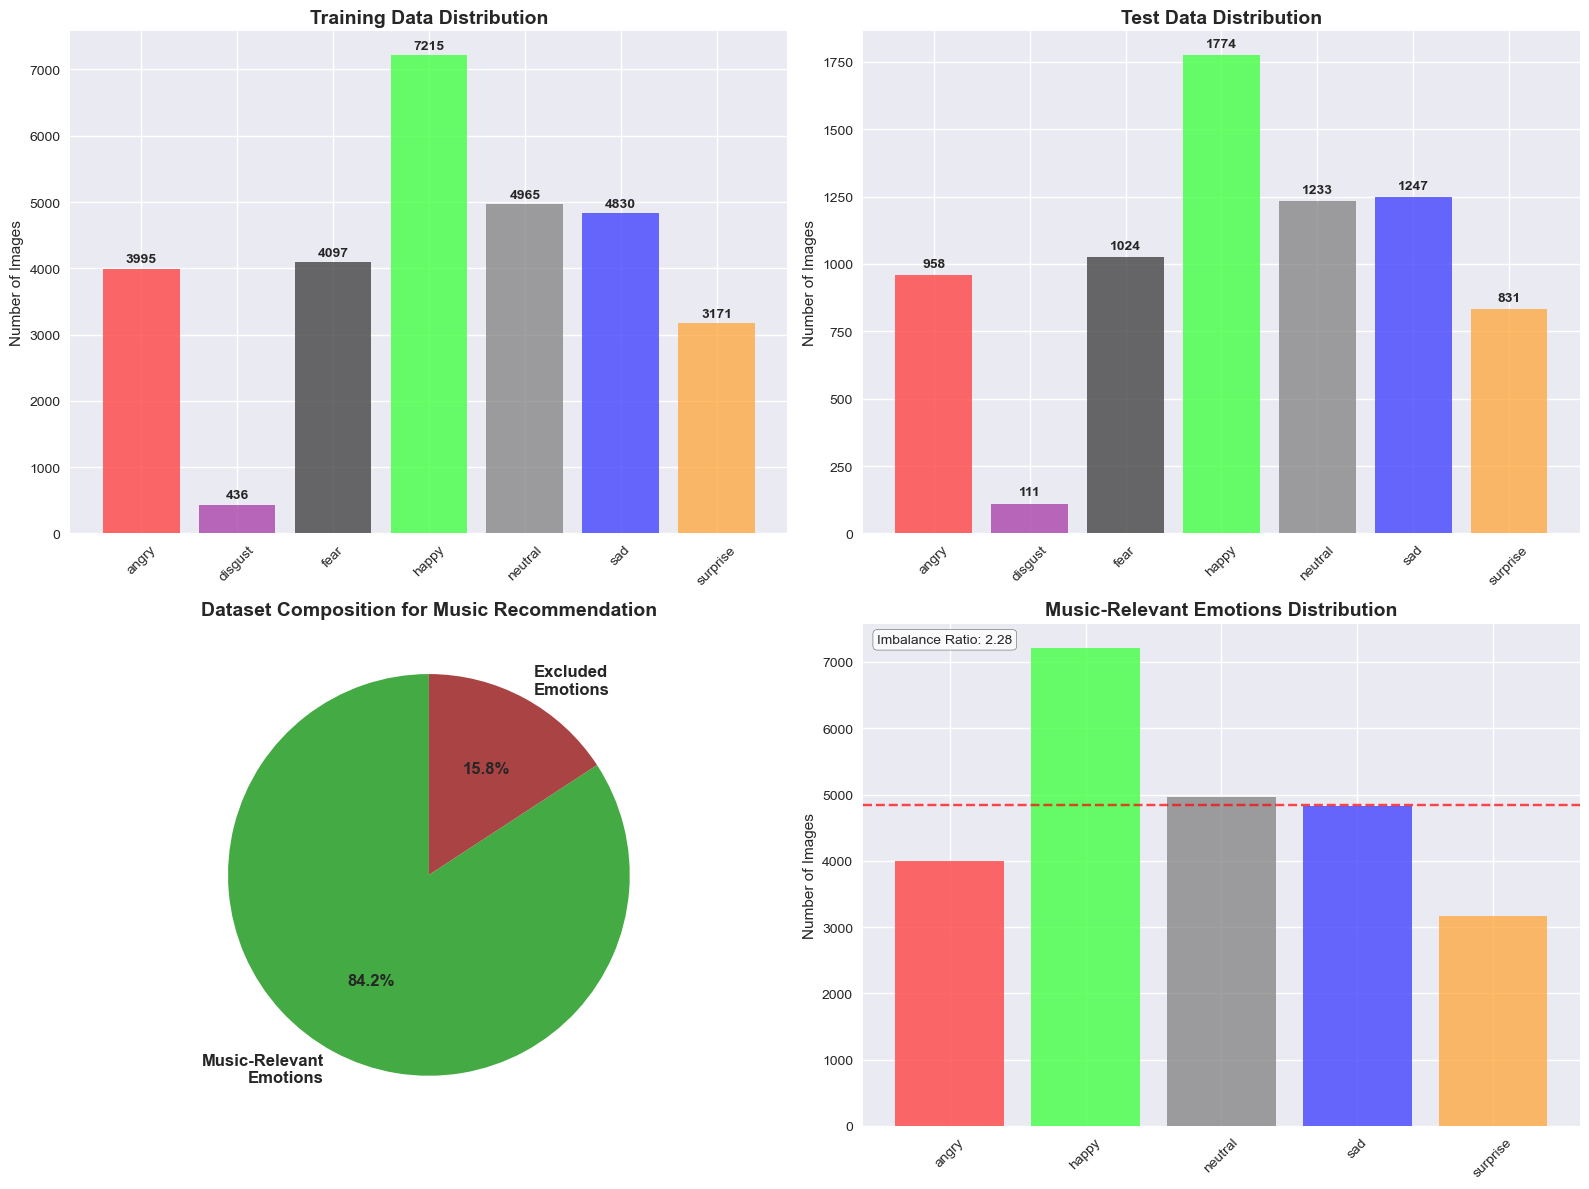

In [3]:
def plot_emotion_distribution(train_stats, test_stats):
    """Create comprehensive distribution plots"""
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Color mapping
    colors = {'angry': '#ff4444', 'disgust': '#aa44aa', 'fear': '#444444', 
              'happy': '#44ff44', 'neutral': '#888888', 'sad': '#4444ff', 'surprise': '#ffaa44'}
    
    # 1. Training data distribution
    emotions = list(train_stats.keys())
    counts = list(train_stats.values())
    bar_colors = [colors.get(emotion, '#666666') for emotion in emotions]
    
    bars1 = axes[0,0].bar(emotions, counts, color=bar_colors, alpha=0.8)
    axes[0,0].set_title('Training Data Distribution', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Number of Images')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, count in zip(bars1, counts):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                      str(count), ha='center', va='bottom', fontweight='bold')
    
    # 2. Test data distribution
    test_emotions = list(test_stats.keys())
    test_counts = list(test_stats.values())
    test_colors = [colors.get(emotion, '#666666') for emotion in test_emotions]
    
    bars2 = axes[0,1].bar(test_emotions, test_counts, color=test_colors, alpha=0.8)
    axes[0,1].set_title('Test Data Distribution', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Number of Images')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, count in zip(bars2, test_counts):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                      str(count), ha='center', va='bottom', fontweight='bold')
    
    # 3. Music-relevant vs excluded emotions
    music_relevant_counts = sum([train_stats.get(e, 0) for e in CONFIG['music_relevant_emotions']])
    excluded_counts = sum([train_stats.get(e, 0) for e in CONFIG['excluded_emotions']])
    
    pie_data = [music_relevant_counts, excluded_counts]
    pie_labels = ['Music-Relevant\nEmotions', 'Excluded\nEmotions']
    pie_colors = ['#44aa44', '#aa4444']
    
    axes[1,0].pie(pie_data, labels=pie_labels, colors=pie_colors, autopct='%1.1f%%',
                 startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
    axes[1,0].set_title('Dataset Composition for Music Recommendation', 
                       fontsize=14, fontweight='bold')
    
    # 4. Class imbalance analysis
    music_emotions = [e for e in emotions if e in CONFIG['music_relevant_emotions']]
    music_counts = [train_stats[e] for e in music_emotions]
    music_colors = [colors[e] for e in music_emotions]
    
    bars4 = axes[1,1].bar(music_emotions, music_counts, color=music_colors, alpha=0.8)
    axes[1,1].set_title('Music-Relevant Emotions Distribution', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Number of Images')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # Add imbalance ratio line
    max_count = max(music_counts)
    min_count = min(music_counts)
    imbalance_ratio = max_count / min_count
    axes[1,1].axhline(y=np.mean(music_counts), color='red', linestyle='--', alpha=0.7)
    axes[1,1].text(0.02, 0.98, f'Imbalance Ratio: {imbalance_ratio:.2f}', 
                  transform=axes[1,1].transAxes, fontsize=10, 
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                  verticalalignment='top')
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['output_dir'], 'emotion_distribution_analysis.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    return music_relevant_counts, excluded_counts, imbalance_ratio

music_count, excluded_count, imbalance_ratio = plot_emotion_distribution(train_distribution, test_distribution)

## 3. Image Quality and Characteristics Analysis

In [4]:
def analyze_image_characteristics():
    """Analyze image quality, size distribution, and pixel statistics"""
    
    image_stats = {
        'sizes': [],
        'pixel_means': [],
        'pixel_stds': [],
        'brightness': [],
        'contrast': [],
        'emotion_stats': defaultdict(lambda: {'means': [], 'stds': [], 'brightness': []})
    }
    
    print("Analyzing image characteristics...")
    
    # Sample images from each emotion for analysis
    sample_size = 100  # Sample size per emotion
    
    for emotion in CONFIG['music_relevant_emotions']:
        emotion_path = os.path.join(CONFIG['train_dir'], emotion)
        if os.path.exists(emotion_path):
            image_files = [f for f in os.listdir(emotion_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Sample random images
            sample_files = np.random.choice(image_files, 
                                          min(sample_size, len(image_files)), 
                                          replace=False)
            
            for img_file in sample_files:
                img_path = os.path.join(emotion_path, img_file)
                try:
                    # Load image
                    image = Image.open(img_path)
                    if image.mode != 'L':
                        image = image.convert('L')
                    
                    # Convert to numpy array
                    img_array = np.array(image)
                    
                    # Calculate statistics
                    pixel_mean = np.mean(img_array)
                    pixel_std = np.std(img_array)
                    brightness = np.mean(img_array) / 255.0
                    contrast = np.std(img_array) / 255.0
                    
                    # Store overall stats
                    image_stats['sizes'].append(image.size)
                    image_stats['pixel_means'].append(pixel_mean)
                    image_stats['pixel_stds'].append(pixel_std)
                    image_stats['brightness'].append(brightness)
                    image_stats['contrast'].append(contrast)
                    
                    # Store emotion-specific stats
                    image_stats['emotion_stats'][emotion]['means'].append(pixel_mean)
                    image_stats['emotion_stats'][emotion]['stds'].append(pixel_std)
                    image_stats['emotion_stats'][emotion]['brightness'].append(brightness)
                    
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    
    return image_stats

image_characteristics = analyze_image_characteristics()
print(f"Analyzed {len(image_characteristics['pixel_means'])} images total")

Analyzing image characteristics...
Analyzed 500 images total


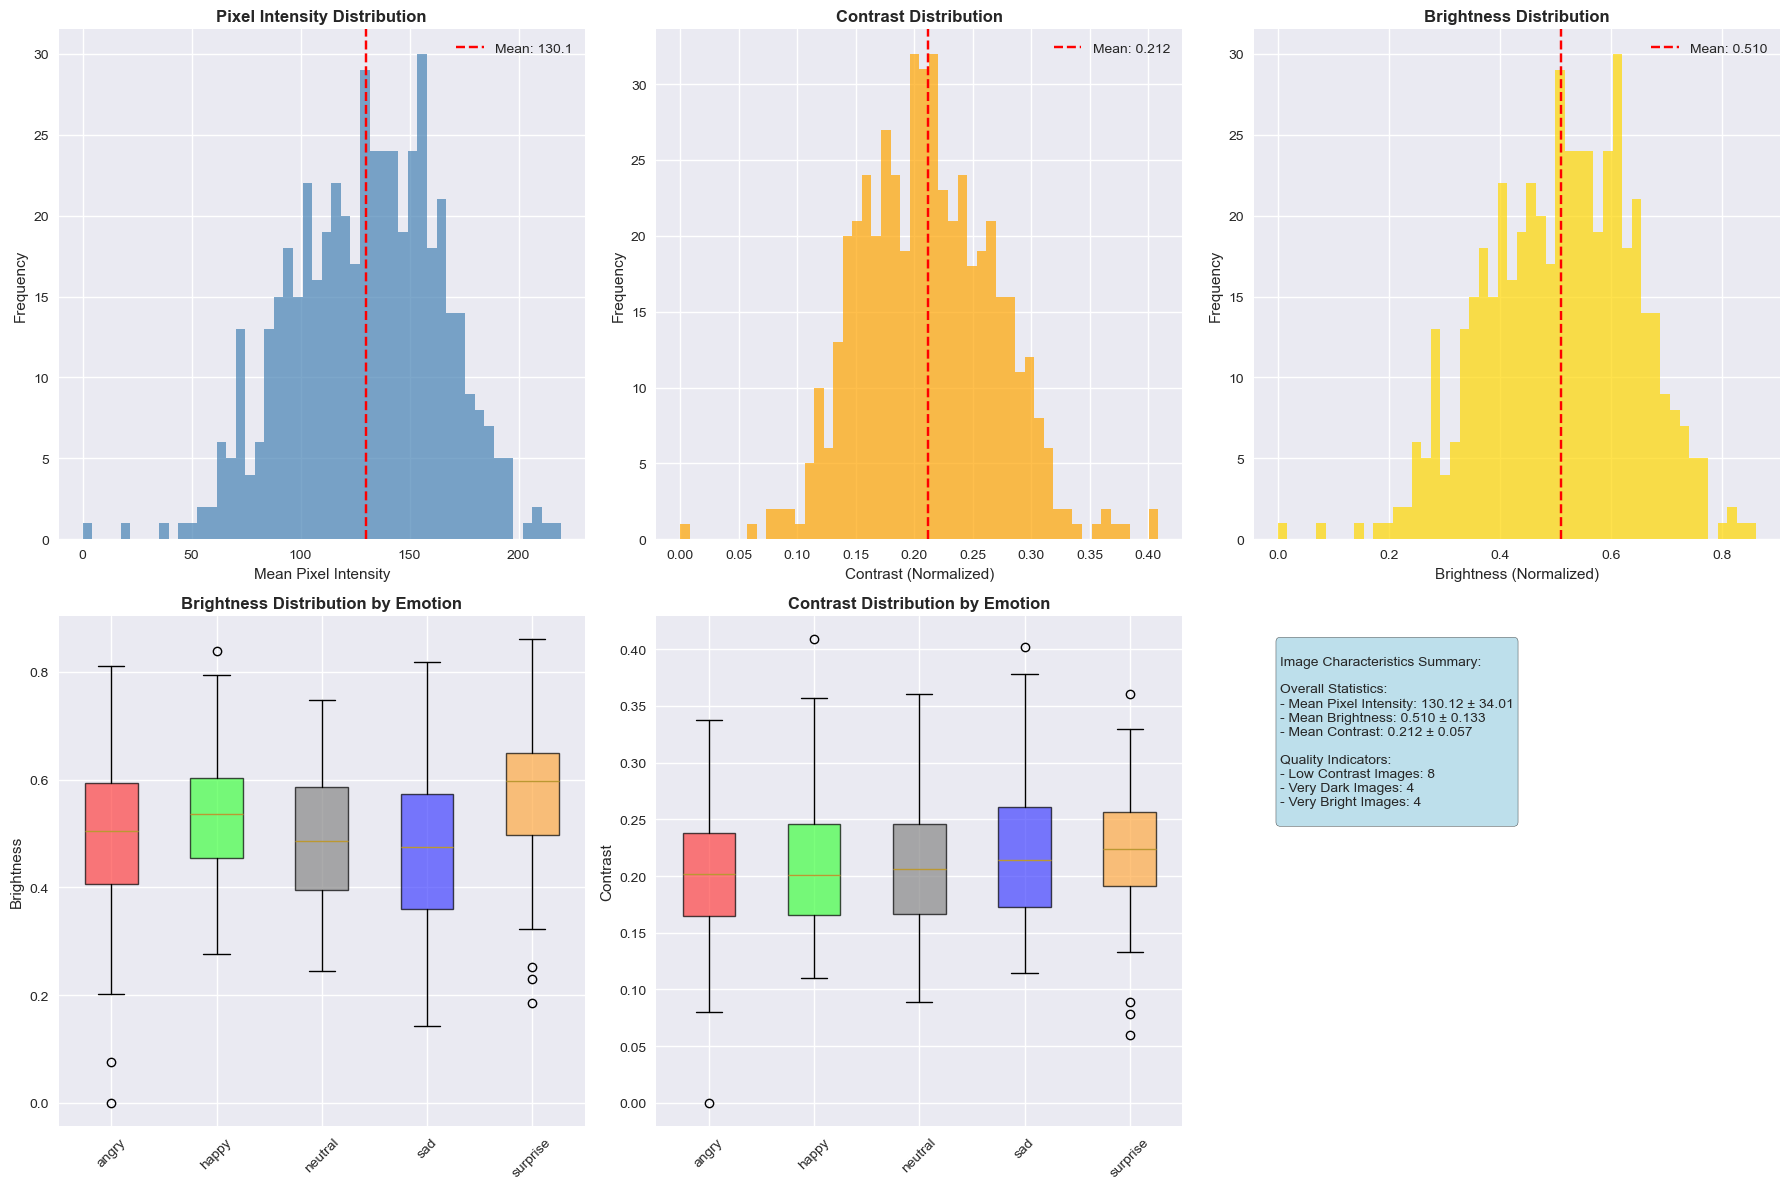

In [5]:
def plot_image_characteristics(image_stats):
    """Plot image quality and characteristics analysis"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Pixel intensity distribution
    axes[0,0].hist(image_stats['pixel_means'], bins=50, alpha=0.7, color='steelblue')
    axes[0,0].set_title('Pixel Intensity Distribution', fontweight='bold')
    axes[0,0].set_xlabel('Mean Pixel Intensity')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].axvline(np.mean(image_stats['pixel_means']), color='red', 
                     linestyle='--', label=f"Mean: {np.mean(image_stats['pixel_means']):.1f}")
    axes[0,0].legend()
    
    # 2. Contrast distribution
    axes[0,1].hist(image_stats['contrast'], bins=50, alpha=0.7, color='orange')
    axes[0,1].set_title('Contrast Distribution', fontweight='bold')
    axes[0,1].set_xlabel('Contrast (Normalized)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].axvline(np.mean(image_stats['contrast']), color='red', 
                     linestyle='--', label=f"Mean: {np.mean(image_stats['contrast']):.3f}")
    axes[0,1].legend()
    
    # 3. Brightness distribution
    axes[0,2].hist(image_stats['brightness'], bins=50, alpha=0.7, color='gold')
    axes[0,2].set_title('Brightness Distribution', fontweight='bold')
    axes[0,2].set_xlabel('Brightness (Normalized)')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].axvline(np.mean(image_stats['brightness']), color='red', 
                     linestyle='--', label=f"Mean: {np.mean(image_stats['brightness']):.3f}")
    axes[0,2].legend()
    
    # 4. Emotion-wise brightness comparison
    emotions = list(image_stats['emotion_stats'].keys())
    brightness_data = [image_stats['emotion_stats'][emotion]['brightness'] for emotion in emotions]
    
    bp1 = axes[1,0].boxplot(brightness_data, labels=emotions, patch_artist=True)
    axes[1,0].set_title('Brightness Distribution by Emotion', fontweight='bold')
    axes[1,0].set_ylabel('Brightness')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Color the boxes
    colors = ['#ff4444', '#44ff44', '#888888', '#4444ff', '#ffaa44']
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # 5. Emotion-wise contrast comparison
    contrast_data = [np.array(image_stats['emotion_stats'][emotion]['stds'])/255.0 for emotion in emotions]
    
    bp2 = axes[1,1].boxplot(contrast_data, labels=emotions, patch_artist=True)
    axes[1,1].set_title('Contrast Distribution by Emotion', fontweight='bold')
    axes[1,1].set_ylabel('Contrast')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # Color the boxes
    for patch, color in zip(bp2['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # 6. Statistical summary
    axes[1,2].axis('off')
    summary_text = f"""
Image Characteristics Summary:

Overall Statistics:
- Mean Pixel Intensity: {np.mean(image_stats['pixel_means']):.2f} ± {np.std(image_stats['pixel_means']):.2f}
- Mean Brightness: {np.mean(image_stats['brightness']):.3f} ± {np.std(image_stats['brightness']):.3f}
- Mean Contrast: {np.mean(image_stats['contrast']):.3f} ± {np.std(image_stats['contrast']):.3f}

Quality Indicators:
- Low Contrast Images: {sum(1 for c in image_stats['contrast'] if c < 0.1)}
- Very Dark Images: {sum(1 for b in image_stats['brightness'] if b < 0.2)}
- Very Bright Images: {sum(1 for b in image_stats['brightness'] if b > 0.8)}
    """
    
    axes[1,2].text(0.05, 0.95, summary_text, transform=axes[1,2].transAxes,
                  fontsize=10, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['output_dir'], 'image_characteristics_analysis.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()

plot_image_characteristics(image_characteristics)

## 4. Sample Images Visualization

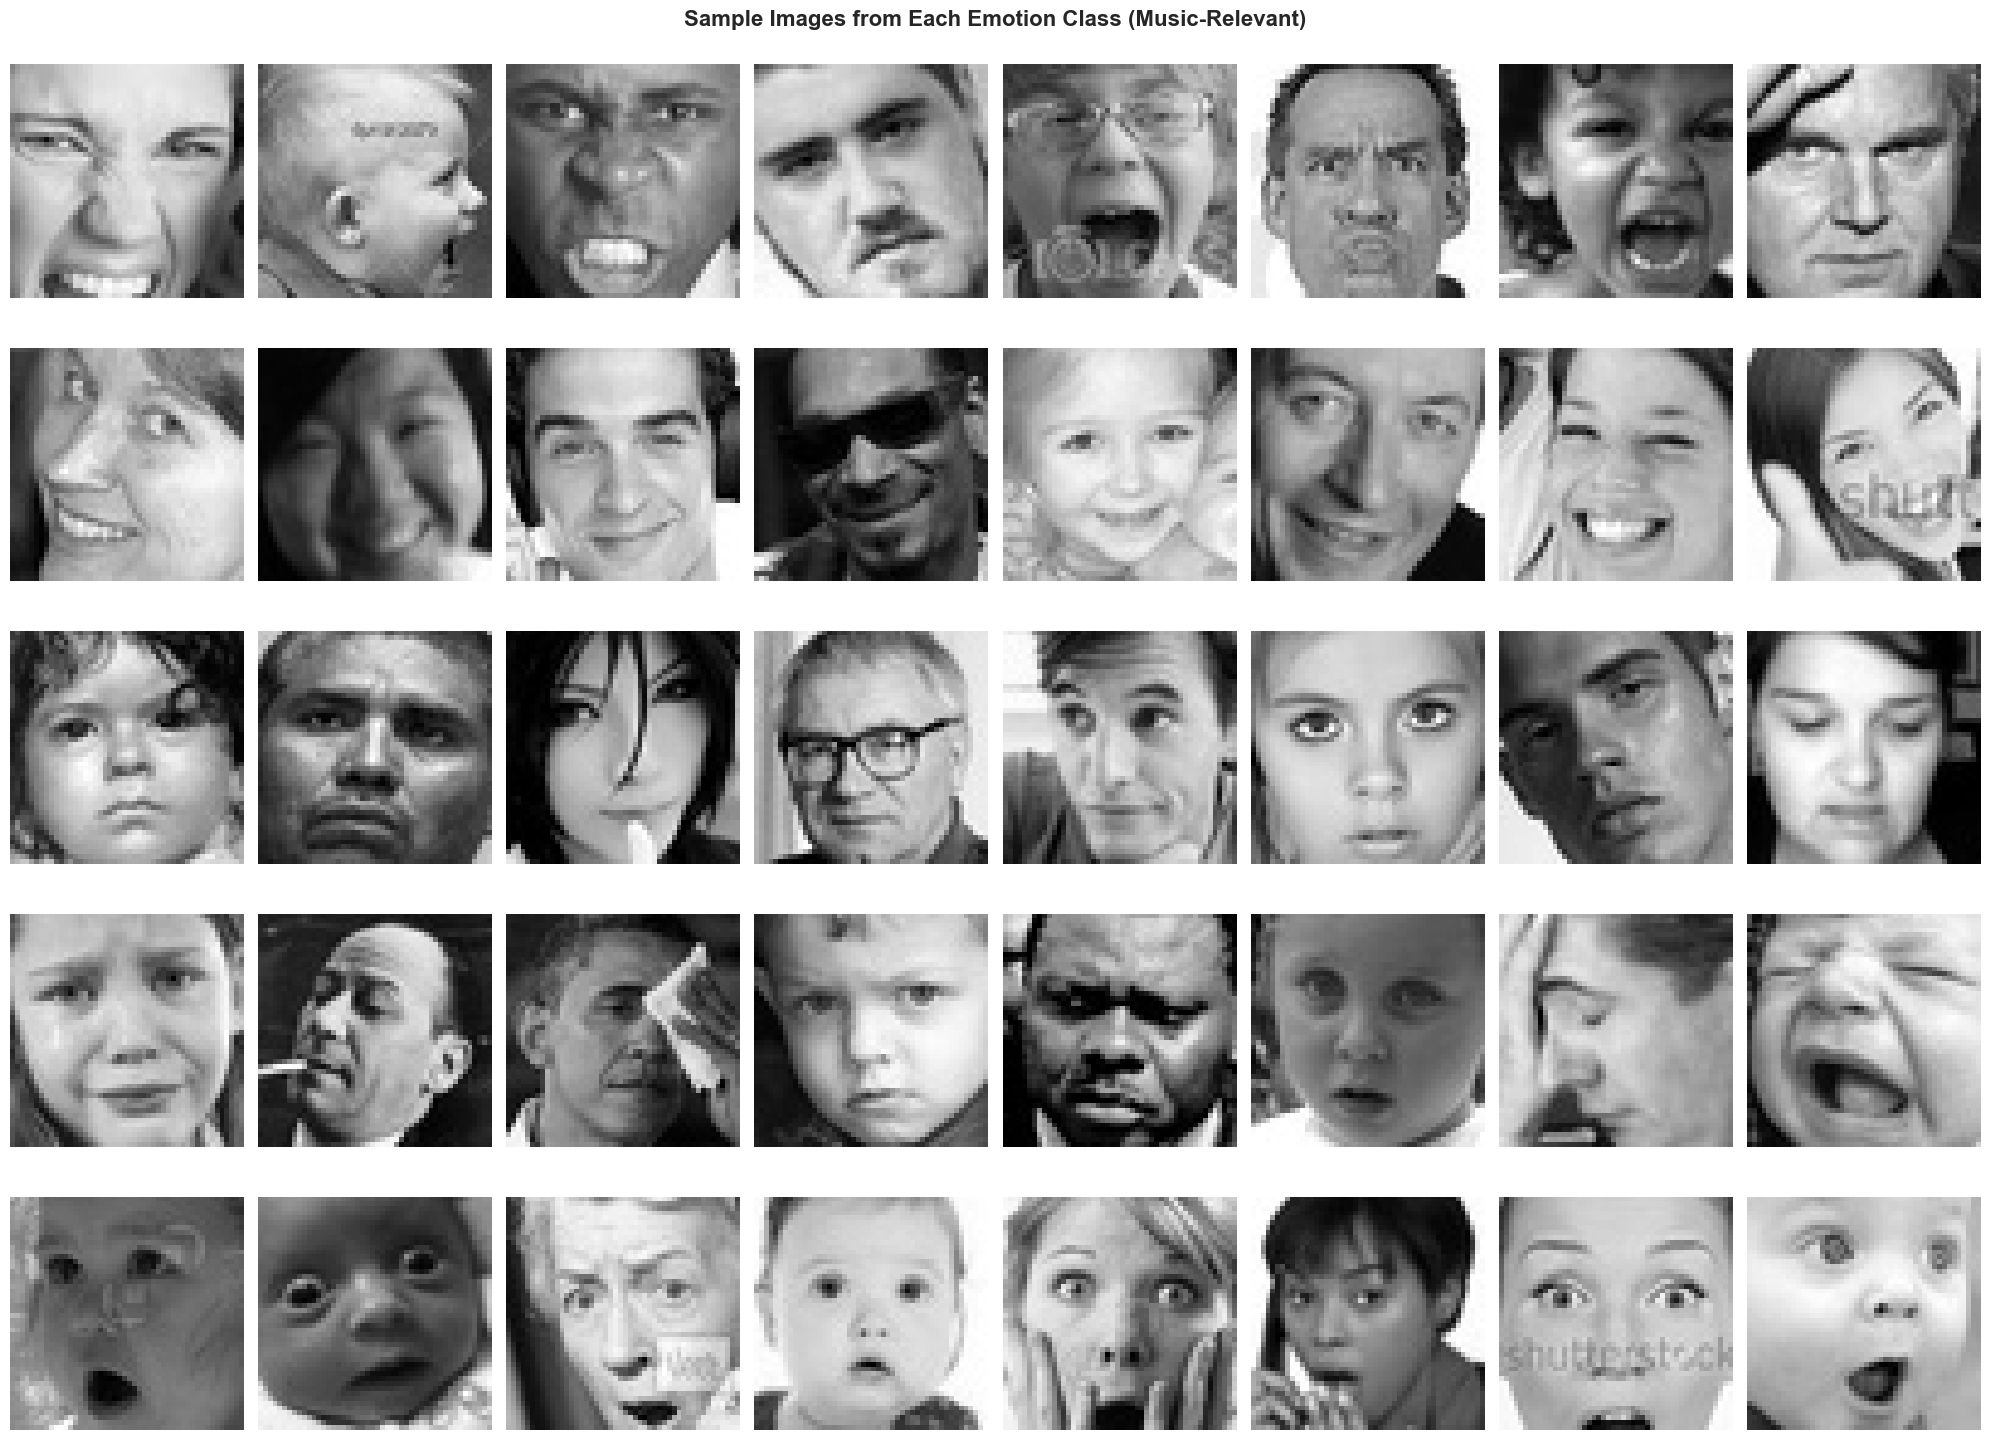

In [6]:
def visualize_sample_images():
    """Display sample images from each emotion class"""
    
    n_samples = 8  # Number of samples per emotion
    emotions = CONFIG['music_relevant_emotions']
    
    fig, axes = plt.subplots(len(emotions), n_samples, figsize=(20, 15))
    
    for i, emotion in enumerate(emotions):
        emotion_path = os.path.join(CONFIG['train_dir'], emotion)
        if os.path.exists(emotion_path):
            image_files = [f for f in os.listdir(emotion_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Sample random images
            sample_files = np.random.choice(image_files, 
                                          min(n_samples, len(image_files)), 
                                          replace=False)
            
            for j, img_file in enumerate(sample_files):
                img_path = os.path.join(emotion_path, img_file)
                try:
                    image = Image.open(img_path)
                    if image.mode != 'L':
                        image = image.convert('L')
                    
                    axes[i,j].imshow(image, cmap='gray')
                    axes[i,j].axis('off')
                    
                    if j == 0:
                        axes[i,j].set_ylabel(emotion.upper(), fontsize=14, fontweight='bold')
                    
                except Exception as e:
                    axes[i,j].text(0.5, 0.5, 'Error', ha='center', va='center')
                    axes[i,j].axis('off')
    
    plt.suptitle('Sample Images from Each Emotion Class (Music-Relevant)', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['output_dir'], 'sample_images_by_emotion.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()

visualize_sample_images()

## 5. Data Quality Assessment

In [7]:
def assess_data_quality():
    """Assess data quality issues and provide recommendations"""
    
    quality_report = {
        'corrupted_images': [],
        'size_inconsistencies': [],
        'very_dark_images': [],
        'very_bright_images': [],
        'low_contrast_images': []
    }
    
    print("Assessing data quality...")
    
    total_images = 0
    processed_images = 0
    
    for emotion in CONFIG['music_relevant_emotions']:
        emotion_path = os.path.join(CONFIG['train_dir'], emotion)
        if os.path.exists(emotion_path):
            image_files = [f for f in os.listdir(emotion_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            for img_file in image_files[:200]:  # Sample first 200 images per emotion
                total_images += 1
                img_path = os.path.join(emotion_path, img_file)
                
                try:
                    image = Image.open(img_path)
                    
                    # Check size consistency
                    if image.size != (48, 48):
                        quality_report['size_inconsistencies'].append({
                            'path': img_path,
                            'size': image.size,
                            'emotion': emotion
                        })
                    
                    # Convert to grayscale and analyze
                    if image.mode != 'L':
                        image = image.convert('L')
                    
                    img_array = np.array(image)
                    brightness = np.mean(img_array) / 255.0
                    contrast = np.std(img_array) / 255.0
                    
                    # Check for quality issues
                    if brightness < 0.15:
                        quality_report['very_dark_images'].append({
                            'path': img_path,
                            'brightness': brightness,
                            'emotion': emotion
                        })
                    
                    if brightness > 0.85:
                        quality_report['very_bright_images'].append({
                            'path': img_path,
                            'brightness': brightness,
                            'emotion': emotion
                        })
                    
                    if contrast < 0.08:
                        quality_report['low_contrast_images'].append({
                            'path': img_path,
                            'contrast': contrast,
                            'emotion': emotion
                        })
                    
                    processed_images += 1
                    
                except Exception as e:
                    quality_report['corrupted_images'].append({
                        'path': img_path,
                        'error': str(e),
                        'emotion': emotion
                    })
    
    # Generate quality report
    print("\nData Quality Assessment Report")
    print("=" * 50)
    print(f"Total Images Analyzed: {total_images}")
    print(f"Successfully Processed: {processed_images}")
    print(f"Corrupted Images: {len(quality_report['corrupted_images'])}")
    print(f"Size Inconsistencies: {len(quality_report['size_inconsistencies'])}")
    print(f"Very Dark Images: {len(quality_report['very_dark_images'])}")
    print(f"Very Bright Images: {len(quality_report['very_bright_images'])}")
    print(f"Low Contrast Images: {len(quality_report['low_contrast_images'])}")
    
    return quality_report

quality_assessment = assess_data_quality()

Assessing data quality...

Data Quality Assessment Report
Total Images Analyzed: 1000
Successfully Processed: 1000
Corrupted Images: 0
Size Inconsistencies: 0
Very Dark Images: 4
Very Bright Images: 3
Low Contrast Images: 2


## 6. Save Analysis Results

In [8]:
def save_analysis_results():
    """Saving analysis results to JSON file if I want to use it later"""
    
    analysis_results = {
        'dataset_info': {
            'original_emotions': CONFIG['original_emotions'],
            'music_relevant_emotions': CONFIG['music_relevant_emotions'],
            'excluded_emotions': CONFIG['excluded_emotions'],
            'train_distribution': train_distribution,
            'test_distribution': test_distribution,
            'total_music_relevant': music_count,
            'total_excluded': excluded_count,
            'class_imbalance_ratio': float(imbalance_ratio)
        },
        'image_characteristics': {
            'mean_pixel_intensity': float(np.mean(image_characteristics['pixel_means'])),
            'std_pixel_intensity': float(np.std(image_characteristics['pixel_means'])),
            'mean_brightness': float(np.mean(image_characteristics['brightness'])),
            'std_brightness': float(np.std(image_characteristics['brightness'])),
            'mean_contrast': float(np.mean(image_characteristics['contrast'])),
            'std_contrast': float(np.std(image_characteristics['contrast']))
        },
        'quality_assessment': {
            'corrupted_images_count': len(quality_assessment['corrupted_images']),
            'size_inconsistencies_count': len(quality_assessment['size_inconsistencies']),
            'very_dark_images_count': len(quality_assessment['very_dark_images']),
            'very_bright_images_count': len(quality_assessment['very_bright_images']),
            'low_contrast_images_count': len(quality_assessment['low_contrast_images'])
        },
        'analysis_date': pd.Timestamp.now().isoformat()
    }
    
    # Save to JSON
    output_file = os.path.join(CONFIG['output_dir'], 'eda_analysis_results.json')
    with open(output_file, 'w') as f:
        json.dump(analysis_results, f, indent=2)
    
    print(f"\nAnalysis results saved to: {output_file}")

save_analysis_results()


Analysis results saved to: ../../data/processed/FC211033_Sahan\eda_analysis_results.json
